In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
retail = pd.read_csv("resources/RSCCASN.csv", parse_dates = True, index_col="DATE")

In [6]:
retail

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


## initial Plot
- From initial plot there is some pattern that occurs monthly for sales
- data is reported at the beginning of every month 

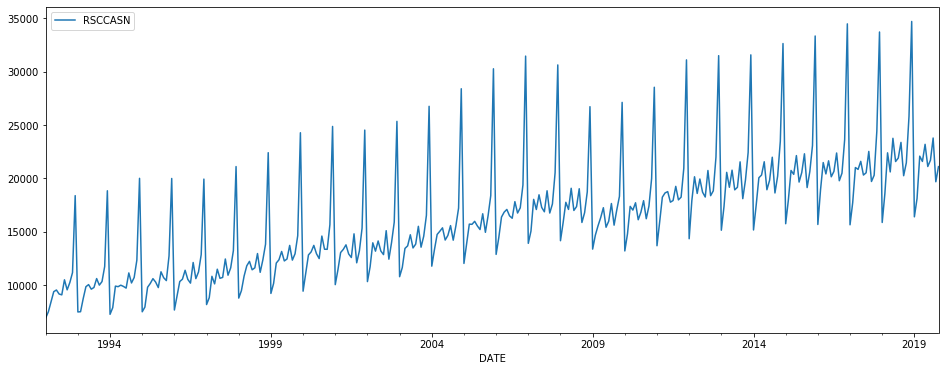

In [8]:
retail.plot(figsize = (16,6))

### Data Consideration
- WE first need to decide how much data we will be using for the model..
- 1.5 years would be a gooe amout of data 
- in this case this would be 18 months 

In [9]:
testing_Data = 18
test_index = len(retail) - testing_Data

In [10]:
test_index

316

In [11]:
len(retail)

334

## Training and Testing Data

In [12]:
train = retail.iloc[:test_index]

In [13]:
test = retail.iloc[test_index:]

In [14]:
test.shape

(18, 1)

In [15]:
train.shape

(316, 1)

### Scaling the data

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scalar = MinMaxScaler()

In [18]:
train_scaled = scalar.fit_transform(train)

In [19]:
test_scaled = scalar.transform(test)

In [20]:
train_scaled.shape

(316, 1)

In [21]:
test_scaled.shape

(18, 1)

## lets batch out data using keras time series generator
- we will take a length of 12 months to train the data on

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
length = 12
generator = TimeseriesGenerator(train_scaled,train_scaled, length = length, batch_size=1)

In [32]:
X,y = generator[0]

In [34]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [35]:
y

array([[0.02047633]])

## validaiting generator
- Generator preditcs the y value accurately so we are good to start training

In [39]:
train_scaled[11:12]

array([[0.41595266]])

## early stopping 
- We will introduce early stopping to the model so that we can set a large epoch and and allow the model to stop training when the val-loss is at its lowest error during training

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [29]:
early = EarlyStopping(monitor="val_loss", patience=2)

## validation generator
- validaiton generator will function as our validation data for training

In [30]:
validaiton_generator = TimeseriesGenerator(test_scaled,test_scaled, length = length, batch_size=1)

## Creating The Model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### tensorBoard Setup

In [41]:
pwd

'/Users/admin/Desktop/python/Portfolio/Recurrent Neural Networks/sales forecastinfg '

In [42]:
path = "board\logs\fit"

board =TensorBoard( log_dir=path,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None,)

In [43]:
n_features = 1

In [44]:
model = Sequential()
model.add(LSTM(units = 100, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(units=1))
model.compile(optimization = "adam", loss = "mse")

### Model Summary

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## Fitting Model

In [46]:
model.fit_generator(generator, validation_data=validaiton_generator, epochs=20, callbacks=[early,board])

Epoch 1/20
304/304 [==============================] - 104s 342ms/step - loss: 0.0232 - val_loss: 0.0452
Epoch 2/20
304/304 [==============================] - 144s 475ms/step - loss: 0.0189 - val_loss: 0.0045
Epoch 3/20
304/304 [==============================] - 154s 506ms/step - loss: 0.0159 - val_loss: 0.0020
Epoch 4/20
304/304 [==============================] - 110s 361ms/step - loss: 0.0108 - val_loss: 0.0021
Epoch 5/20
304/304 [==============================] - 100s 328ms/step - loss: 0.0073 - val_loss: 0.0037


### Evaluating the model
- model looks to have worked propely and stopped where the loss was at the minimum error

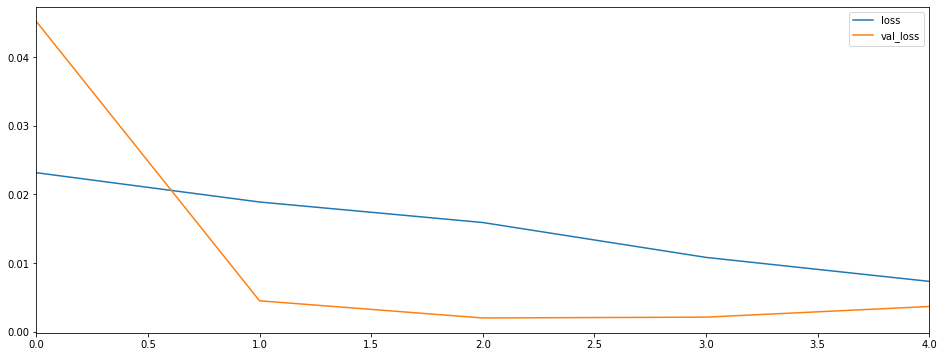

In [49]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

### Prediciton Test
- how does our model perform with predictions

In [51]:
test_predicitons = []
first_batch = train_scaled[-length:]
current_batch = first_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_prediciton = model.predict(current_batch)[0]
    test_predicitons.append(current_prediciton)
    current_batch = np.append(current_batch[:,1:,:],[[current_prediciton]], axis=1)

## predictions
- Out predicitons are based on scaled data so we need to inverse this process

In [52]:
test_predicitons

[array([0.55539125], dtype=float32),
 array([0.5250137], dtype=float32),
 array([0.5380554], dtype=float32),
 array([0.5967868], dtype=float32),
 array([0.52339387], dtype=float32),
 array([0.5555039], dtype=float32),
 array([0.68730587], dtype=float32),
 array([0.9971831], dtype=float32),
 array([0.36053506], dtype=float32),
 array([0.45648524], dtype=float32),
 array([0.5749513], dtype=float32),
 array([0.5333906], dtype=float32),
 array([0.5888829], dtype=float32),
 array([0.5705561], dtype=float32),
 array([0.58763254], dtype=float32),
 array([0.6374767], dtype=float32),
 array([0.5814658], dtype=float32),
 array([0.61955845], dtype=float32)]

In [53]:
true_predictions = scalar.inverse_transform(test_predicitons)

In [55]:
true_predictions

array([[22235.69664621],
       [21398.97694588],
       [21758.19848633],
       [23375.89553785],
       [21354.36073875],
       [22238.79955435],
       [25869.15281916],
       [34404.41087914],
       [16868.57756591],
       [19511.42949605],
       [22774.45836163],
       [21629.71017981],
       [23158.19123459],
       [22653.39733362],
       [23123.75059605],
       [24496.65774727],
       [22953.89346457],
       [24003.11804485]])

### True predictions and test data
-Looks like our model is predicting pretty we ll especially for months such as julyaug, jan, april may

In [57]:
test["predictions"] = true_predictions

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


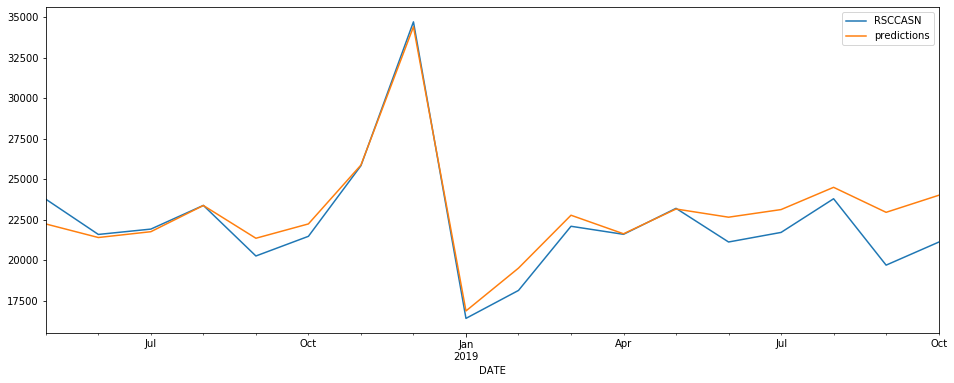

In [60]:
test.plot(figsize= (16,6))

## Forecasting
-Since our model is doing pretty well with predicitons lets try to forecast a few days in to the future
- We will scale our entire data set
- and retrain our model 

In [61]:
full_Scalar  =MinMaxScaler()

In [62]:
retail_scaled = full_Scalar.fit_transform(retail)

## We will forecast 12 month into the future

In [63]:
length = 12
gen = TimeseriesGenerator(retail_scaled, retail_scaled, length = length, batch_size=1)

### Model creation

In [64]:
model = Sequential()
model.add(LSTM(units = 100, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(units = 1))
model.compile(optimization  = "adam", loss = "mse")

#### No Early Stopping 
- We have no validation data to use in a validaiton generator so we will not be able to use a validaiton or rarly stopping

In [65]:
model.fit_generator(gen, epochs=10)

Epoch 1/10
322/322 [==============================] - 117s 362ms/step - loss: 0.0224
Epoch 2/10
322/322 [==============================] - 116s 360ms/step - loss: 0.0179
Epoch 3/10
322/322 [==============================] - 116s 361ms/step - loss: 0.0138
Epoch 4/10
322/322 [==============================] - 115s 356ms/step - loss: 0.0103
Epoch 5/10
322/322 [==============================] - 117s 362ms/step - loss: 0.0049
Epoch 6/10
322/322 [==============================] - 124s 384ms/step - loss: 0.0032
Epoch 7/10
322/322 [==============================] - 119s 371ms/step - loss: 0.0028
Epoch 8/10
322/322 [==============================] - 122s 379ms/step - loss: 0.0027
Epoch 9/10
322/322 [==============================] - 113s 352ms/step - loss: 0.0023
Epoch 10/10
322/322 [==============================] - 113s 352ms/step - loss: 0.0020


## Forecasting

In [68]:
forecast = []
periods = length
first_batch = retail_scaled[-length:]
current_batch = first_batch.reshape((1,length,n_features))

for i in range(periods):
    current_predicitons = model.predict(current_batch)[0]
    forecast.append(current_predicitons)
    current_batch = np.append(current_batch[:,1:,:], [[current_predicitons]], axis = 1)

In [69]:
forecast

[array([0.62878364], dtype=float32),
 array([0.9454462], dtype=float32),
 array([0.40102607], dtype=float32),
 array([0.44319606], dtype=float32),
 array([0.53048706], dtype=float32),
 array([0.5193316], dtype=float32),
 array([0.55883306], dtype=float32),
 array([0.5076912], dtype=float32),
 array([0.5193797], dtype=float32),
 array([0.57047], dtype=float32),
 array([0.47582185], dtype=float32),
 array([0.50234354], dtype=float32)]

## inverse scale forecast

In [70]:
true_forecast = full_Scalar.inverse_transform(forecast)

In [71]:
true_forecast

array([[24398.06420565],
       [33191.14989328],
       [18073.69191504],
       [19244.66814613],
       [21668.56469727],
       [21358.79915905],
       [22455.67648363],
       [21035.56936789],
       [21360.13482618],
       [22778.81027889],
       [20150.62120533],
       [20887.07529163]])

### Adding  Forecast
- we need to forecast the data 12 months after the last month in the original "Retail" data set
- So from 2019-20-01 on..

In [74]:
retail.tail()

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


## Generating Dates 
- Generating date index for the 12 month forecast

In [77]:
date_time_forecast = pd.date_range(start="2019-11-01", periods=periods, freq="MS")

In [90]:
date_time_forecast

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

## forecast Data_frame

In [78]:
forecast_df = pd.DataFrame(true_forecast, index=date_time_forecast)

### Forecast Plot
- Appears we are forecasting pretty well in to the next 12 months

(576, 609)

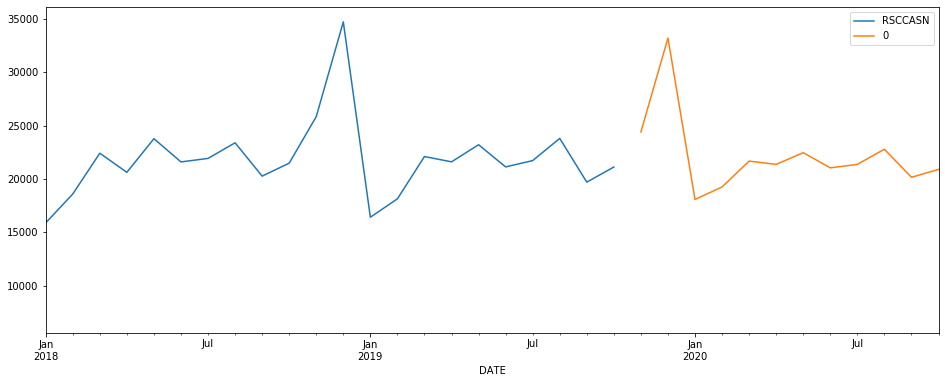

In [91]:
ax = retail.plot(figsize = (16,6))
forecast_df.plot(ax = ax)
plt.xlim("2018-1-1", '2020-10-01')